[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/pinecone-io/examples/blob/master/learn/search/hybrid-search/ecommerce-search/ecommerce-search.ipynb) [![Open nbviewer](https://raw.githubusercontent.com/pinecone-io/examples/master/assets/nbviewer-shield.svg)](https://nbviewer.org/github/pinecone-io/examples/blob/master/learn/search/hybrid-search/ecommerce-search/ecommerce-search.ipynb)

# Hybrid Search for E-Commerce with Pinecone


Hybrid vector search is combination of traditional keyword search and modern dense vector search. It has emerged as a powerful tool for e-commerce companies looking to improve the search experience for their customers.

By combining the strengths of traditional text-based search algorithms with the visual recognition capabilities of deep learning models, hybrid vector search allows users to search for products using a combination of text and images. This can be especially useful for product searches, where customers may not know the exact name or details of the item they are looking for.

Pinecone's new **sparse-dense index** allows you to seamlessly perform hybrid search for e-commerce or in any other context. This notebook demonstrates how to use the new hybrid search feature to improve e-commerce search.

## Install Dependencies

First, let's import the necessary libraries


In [ ]:
!pip install Pinecone

ERROR: Could not find a version that satisfies the requirement Pinecone (from versions: none)
ERROR: No matching distribution found for Pinecone


In [ ]:
!pip install -qU datasets transformers sentence-transformers pinecone-client pinecone-text protobuf==3.20.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 32.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 8.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.9/199.9 kB 19.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 52.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


## Connect to Pinecone

Let's initiate a connection and create an index. For this, we need a [free API key](https://app.pinecone.io/), and then we initialize the connection like so:

In [ ]:
import os
from pinecone import Pinecone

# initialize connection to pinecone (get API key at app.pinecone.io)
api_key = os.getenv("PINECONE_API_KEY") or "PINECONE_API_KEY"
# find your environment next to the api key in pinecone console
env = os.getenv("PINECONE_ENVIRONMENT") or "PINECONE_ENVIRONMENT"

# init connection to pinecone
# pinecone.init(
#     api_key='d3f75c33-f870-4c04-a4ce-36380d671fbc',
#     environment='gcp-starter'
# )

#Splade
pc=Pinecone(
    api_key='5b417530-2f89-48d5-ba91-175ec6b2ba9f',
    environment='eu-west4-gcp'
)

To use the `sparse-dense` index in Pinecone we must set `metric="dotproduct"` and use either `s1` or `p1` pods. We also align the `dimension` value to that of our retrieval model, which outputs `512`-dimensional vectors.

In [ ]:
# choose a name for your index
index_name = "hybrid"


Now we have created the sparse-dense enabled index, we connect to it:

In [ ]:
index = pc.Index(index_name)

*Note: we are using `GRPCIndex` rather than `Index` for the improved upsert speeds, either can be used with the sparse-dense index.*

# Load Dataset

We will work with a subset of the [Open Fashion Product Images](https://www.kaggle.com/datasets/paramaggarwal/fashion-product-images-small) dataset, consisting of ~44K fashion products with images and category labels describing the products. The dataset can be loaded from the Huggigface Datasets hub as follows:

In [ ]:
from datasets import load_dataset

# load the dataset from huggingface datasets hub
fashion = load_dataset(
    "ashraq/fashion-product-images-small",
    split="train"
)
fashion

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/44072 [00:00<?, ? examples/s]

Dataset({
    features: ['id', 'gender', 'masterCategory', 'subCategory', 'articleType', 'baseColour', 'season', 'year', 'usage', 'productDisplayName', 'image'],
    num_rows: 44072
})

We will first assign the images and metadata into separate variables and then convert the metadata into a pandas dataframe.

In [ ]:
# assign the images and metadata to separate variables
images = fashion["image"]
metadata = fashion.remove_columns("image")

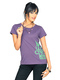

In [ ]:
# display a product image
images[980]

In [ ]:
# convert metadata into a pandas dataframe
metadata = metadata.to_pandas()
metadata.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt


We need both sparse and dense vectors to perform hybrid search. We will use all the metadata fields except for the `id` and `year` to create sparse vectors and the product images to create dense vectors.

In [ ]:
metadata1=metadata[['id','productDisplayName']]

In [ ]:
metadata1

,id,productDisplayName
0,15970,Turtle Check Men Navy Blue Shirt
1,39386,Peter England Men Party Blue Jeans
2,59263,Titan Women Silver Watch
3,21379,Manchester United Men Solid Black Track Pants
4,53759,Puma Men Grey T-shirt
...,...,...
44067,17036,Gas Men Caddy Casual Shoe
44068,6461,Lotto Men's Soccer Track Flip Flop
44069,18842,Puma Men Graphic Stellar Blue Tshirt
44070,46694,Rasasi Women Blue Lady Perfume


In [ ]:
metadata=metadata1

In [ ]:
metadata

,id,productDisplayName
0,15970,Turtle Check Men Navy Blue Shirt
1,39386,Peter England Men Party Blue Jeans
2,59263,Titan Women Silver Watch
3,21379,Manchester United Men Solid Black Track Pants
4,53759,Puma Men Grey T-shirt
...,...,...
44067,17036,Gas Men Caddy Casual Shoe
44068,6461,Lotto Men's Soccer Track Flip Flop
44069,18842,Puma Men Graphic Stellar Blue Tshirt
44070,46694,Rasasi Women Blue Lady Perfume


## Sparse Vectors

To create the sparse vectors we'll use BM25. We import the BM25 function from the [`pinecone-text` library](https://github.com/pinecone-io/pinecone-text).

In [ ]:
"Turtle Check Men Navy Blue Shirt".lower().split()

['turtle', 'check', 'men', 'navy', 'blue', 'shirt']

BM25 requires training on a representative portion of the dataset. We do this like so:

Let's create a test sparse vector using a `productDisplayName`.

In [ ]:
metadata['productDisplayName'][0]

'Turtle Check Men Navy Blue Shirt'

And for the stored docs, we only need the "IDF" part:

## Dense Vectors

We will use the CLIP to generate dense vectors for product images. We can directly pass PIL images to CLIP as it can encode both images and texts. We can load CLIP like so:

In [ ]:
from sentence_transformers import SentenceTransformer
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# load a CLIP model from huggingface
model = SentenceTransformer(
    'sentence-transformers/clip-ViT-B-32',
    device=device
)


.gitattributes:   0%|          | 0.00/690 [00:00<?, ?B/s]

0_CLIPModel/config.json:   0%|          | 0.00/4.03k [00:00<?, ?B/s]

0_CLIPModel/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

0_CLIPModel/preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

0_CLIPModel/special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

0_CLIPModel/tokenizer_config.json:   0%|          | 0.00/604 [00:00<?, ?B/s]

0_CLIPModel/vocab.json:   0%|          | 0.00/961k [00:00<?, ?B/s]

README.md:   0%|          | 0.00/1.88k [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

In [ ]:
model

SentenceTransformer(
  (0): CLIPModel()
)

In [ ]:
dense_vec = model.encode([metadata['productDisplayName'][0]])
dense_vec.shape

(1, 512)

The model gives us a `512` dimensional dense vector.

## Upsert Documents

Now we can go ahead and generate sparse and dense vectors for the full dataset and upsert them along with the metadata to the new hybrid index. We can do that easily as follows:

In [ ]:
from pinecone_text.sparse import SpladeEncoder

In [ ]:
splade = SpladeEncoder()

tokenizer_config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/670 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

In [ ]:
a=splade.encode_documents(metadata['productDisplayName'][1])
b=splade.encode_documents(metadata['productDisplayName'][2])

In [ ]:
print(len(a['indices']))
print(len(a['values']))

49
49


In [ ]:
print(len(b['indices']))
print(len(b['values']))

56
56


In [ ]:
from tqdm.auto import tqdm

batch_size = 200

for i in tqdm(range(0, len(fashion), batch_size)):
    # find end of batch
    i_end = min(i+batch_size, len(fashion))
    # extract metadata batch
    meta_batch = metadata.iloc[i:i_end]
    meta_dict = meta_batch.to_dict(orient="records")
    # concatinate all metadata field except for id and year to form a single string
    meta_batch = [" ".join(x) for x in meta_batch.loc[:, ~meta_batch.columns.isin(['id', 'year'])].values.tolist()]
    # extract image batch
    img_batch = images[i:i_end]
    # create sparse Splade vectors
    sparse_embeds = splade.encode_documents([text for text in meta_batch])
    # create dense vectors
    dense_embeds = model.encode(img_batch).tolist()
    # create unique IDs
    ids = [str(x) for x in range(i, i_end)]

    upserts = []
    # loop through the data and create dictionaries for uploading documents to pinecone index
    for _id, sparse, dense, meta in zip(ids, sparse_embeds, dense_embeds, meta_dict):
        upserts.append({
            'id': _id,
            'sparse_values': sparse,
            'values': dense,
            'metadata': meta
        })
    # upload the documents to the new hybrid index
    index.upsert(upserts)

# show index description after uploading the documents
index.describe_index_stats()

  0%|          | 0/221 [00:00<?, ?it/s]

{'dimension': 512,
 'index_fullness': 0.0,
 'namespaces': {'': {'vector_count': 44072}},
 'total_vector_count': 44072}

In [ ]:
index.describe_index_stats()

{'dimension': 512,
 'index_fullness': 0.0,
 'namespaces': {'': {'vector_count': 44072}},
 'total_vector_count': 44072}

In [ ]:
index.fetch(["643"])

{'namespace': '',
 'vectors': {'643': {'id': '643',
                     'metadata': {'id': 6422.0,
                                  'productDisplayName': 'Lotto Unisex Canvas '
                                                        'Black Grey Shoe'},
                     'sparse_values': {'indices': [1012,
                                                   1020,
                                                   1996,
                                                   2304,
                                                   2317,
                                                   2417,
                                                   2595,
                                                   2601,
                                                   2630,
                                                   2806,
                                                   2843,
                                                   2858,
                                                   2944,
    

## Querying

Now we can query the index, providing the sparse and dense vectors. We do this directly with an equal weighting between sparse and dense like so:

In [ ]:
query = "men Watch"

# create sparse and dense vectors
# sparse = bm25.encode_queries(query)
sparse = splade.encode_queries(query)
dense = model.encode(query).tolist()
# search
result = index.query(
    top_k=14,
    vector=dense,
    sparse_vector=sparse,
    include_metadata=True,
    include_values = True
)
result
# used returned product ids to get images
# imgs = [images[int(r["id"])] for r in result["matches"]]
# imgs

{'matches': [{'id': '33142',
              'metadata': {'articleType': 'Watches',
                           'baseColour': 'Steel',
                           'gender': 'Men',
                           'id': 54647.0,
                           'masterCategory': 'Accessories',
                           'productDisplayName': 'Fastrack Men Black Dial '
                                                 'Watch',
                           'season': 'Winter',
                           'subCategory': 'Watches',
                           'usage': 'Casual',
                           'year': 2016.0},
              'score': 45.868969,
              'values': []},
             {'id': '33068',
              'metadata': {'articleType': 'Watches',
                           'baseColour': 'White',
                           'gender': 'Men',
                           'id': 51563.0,
                           'masterCategory': 'Accessories',
                           'productDisplayName': 'Fastrac

We return a list of PIL image objects, to view them we will define a function called `display_result`.

In [ ]:
from IPython.core.display import HTML
from io import BytesIO
from base64 import b64encode

# function to display product images
def display_result(image_batch):
    figures = []
    for img in image_batch:
        b = BytesIO()
        img.save(b, format='png')
        figures.append(f'''
            <figure style="margin: 5px !important;">
              <img src="data:image/png;base64,{b64encode(b.getvalue()).decode('utf-8')}" style="width: 90px; height: 120px" >
            </figure>
        ''')
    return HTML(data=f'''
        <div style="display: flex; flex-flow: row wrap; text-align: center;">
        {''.join(figures)}
        </div>
    ''')

And now we can view them:


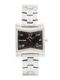
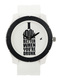
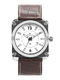
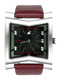
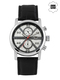
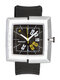
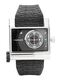
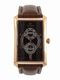
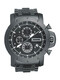
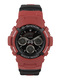
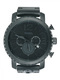
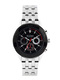
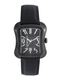
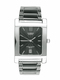

In [ ]:
display_result(imgs)

It's possible to prioritize our search based on sparse vs. dense vector results. To do so, we scale the vectors, for this we'll use a function named `hybrid_scale`.

In [ ]:
def hybrid_scale(dense, sparse, alpha: float):
    """Hybrid vector scaling using a convex combination

    alpha * dense + (1 - alpha) * sparse

    Args:
        dense: Array of floats representing
        sparse: a dict of `indices` and `values`
        alpha: float between 0 and 1 where 0 == sparse only
               and 1 == dense only
    """
    if alpha < 0 or alpha > 1:
        raise ValueError("Alpha must be between 0 and 1")
    # scale sparse and dense vectors to create hybrid search vecs
    hsparse = {
        'indices': sparse['indices'],
        'values':  [v * (1 - alpha) for v in sparse['values']]
    }
    hdense = [v * alpha for v in dense]
    return hdense, hsparse

First, we will do a pure sparse vector search by setting the alpha value as 0.

In [ ]:
question = "Titan Women Watch"

# scale sparse and dense vectors
hdense, hsparse = hybrid_scale(dense, sparse, alpha=0)
# search
result = index.query(
    top_k=14,
    vector=hdense,
    sparse_vector=hsparse,
    include_metadata=True
)
# used returned product ids to get images
imgs = [images[int(r["id"])] for r in result["matches"]]
# display the images
display_result(imgs)

NameError: ignored

Let's take a look at the description of the result.

In [ ]:
for x in result["matches"]:
    print(x["metadata"]['productDisplayName'])

Casio Vintage Collection Digital Watch F-94WA-9DG(D053)
Casio Enticer Men Silver Analogue Watches (A221) MTP-1247D-9AVDF
Casio Enticer Men Silver Analogue  Watch MTP-1165A-1C2DF(A261)
Casio Enticer Men Silver-Toned Dial Analogue Watch MTP-1165A-1CDF(A132)
Casio Enticer Men Silver Multi-Dial Analogue Watch MTP-1300D-1AVDF(A483)
Casio Enticer Men Silver Analogue Watch MTP-1216A-1BDF(A355)
Casio Enticer Men Silver Analogue Watch MTP-1165A-7CDF(A134)
Casio Enticer Men White Dial Analogue Watch MTP-1216A-7BDF(A357)
Casio Enticer Men Black Multi-Dial Analogue Watch MTP-1191A-1ADF(A170)
Casio Enticer Men Silver Analogue Watch MTP-1165A-7C2DF(A263)
Casio Enticer Men Steel-Toned Analogue Watch MTP-1214A-7AVDF(A344)
Casio Enticer Men Brown Analogue Watch MTP-1314L-7AVDF(A553)
Casio Enticer Men Black Analogue Watch MTP-1302L-7BVDF(A490)
Citizen Men Steel-Toned Watch AN8010-55A


We can observe that the keyword search returned French Connection jeans but failed to rank the men's French Connection jeans higher than a few of the women's. Now let's do a pure semantic image search by setting the alpha value to 1.


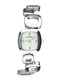
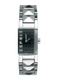
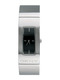
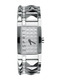
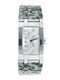
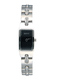
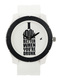
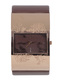
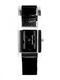
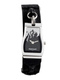
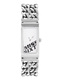
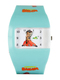
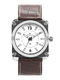
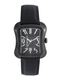

In [ ]:
# scale sparse and dense vectors
hdense, hsparse = hybrid_scale(dense, sparse, alpha=1)
# search
result = index.query(
    top_k=14,
    vector=hdense,
    sparse_vector=hsparse,
    include_metadata=True
)
# used returned product ids to get images
imgs = [images[int(r["id"])] for r in result["matches"]]
# display the images
display_result(imgs)

In [ ]:
for x in result["matches"]:
    print(x["metadata"]['productDisplayName'])

Fossil Women Silver-Toned Dial Watch ES1869
Esprit Women Pure Black Glam Rock Houston Steel Watches
DKNY Women Black Dial Watch NY4624
Esprit Women Silver Glam Rock Houston Steel Watches
Esprit Women Twist Houston White Watches
DKNY Women Black Dial Watch NY3430
Fastrack Men White Watch
Ed Hardy Women Brown Dial Watch
Fastrack Women Black Dial Watch 2166SL01
Fastrack Women Black Dial Watch
Miss Sixty Silver Dial Watch
Chhota Bheem Analog Kids-Boys Torquoise Blue Watch
Maxima Men White Dial Attivo Watch
Morellato Men Black Watch


The semantic image search correctly returned blue jeans for men, but mostly failed to match the exact brand we are looking for — French Connection. Now let's set the alpha value to `0.05` to try a hybrid search that is slightly more dense than sparse search.


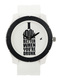
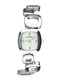
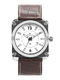
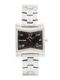
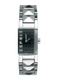
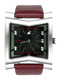
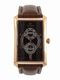
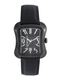
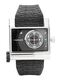
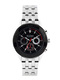
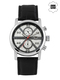
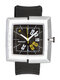
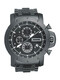
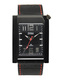

In [ ]:
# scale sparse and dense vectors
hdense, hsparse = hybrid_scale(dense, sparse, alpha=0.7)
# search
result = index.query(
    top_k=14,
    vector=hdense,
    sparse_vector=hsparse,
    include_metadata=True
)
# used returned product ids to get images
imgs = [images[int(r["id"])] for r in result["matches"]]
# display the images
display_result(imgs)

In [ ]:
for x in result["matches"]:
    print(x["metadata"]['productDisplayName'])

Fastrack Men White Watch
Fossil Women Silver-Toned Dial Watch ES1869
Maxima Men White Dial Attivo Watch
Fastrack Men Black Dial Watch
Esprit Women Pure Black Glam Rock Houston Steel Watches
Fastrack Men Smooth Finish Strap Black Watches
Titan Men Brown Watch
Morellato Men Black Watch
Fastrack Men Grey Dial Watch
Titan Men Black Dial Watch
GIORDANO Men Silver-Toned Dial Watch 1575-02
Fastrack Men Economy 2 Analg Black Watch
Fossil Men Black Dial Chronograph Watch JR1266
Maxima Men Black Dial Watch


By performing a mostly sparse search with some help from our image-based dense vectors, we get a strong number of French Connection jeans, that are for men, and visually are almost all aligned to blue jeans.

Let's try more queries.

In [ ]:
query = "Titan Women Silver Watch"
# create sparse and dense vectors
sparse = splade.encode_queries(query)
dense = model.encode(query).tolist()
# scale sparse and dense vectors - keyword search first
hdense, hsparse = hybrid_scale(dense, sparse, alpha=1)
# search
result = index.query(
    top_k=14,
    vector=hdense,
    sparse_vector=hsparse,
    include_metadata=True
)
# used returned product ids to get images
imgs = [images[int(r["id"])] for r in result["matches"]]
# display the images
display_result(imgs)

NameError: ignored

We get a lot of small handbags for women, but they're not beige. Let's use the image dense vectors to weigh the colors higher.


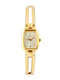
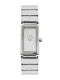
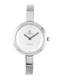
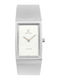
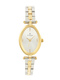
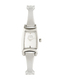
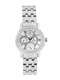
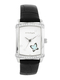
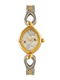
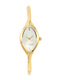
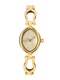
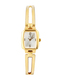
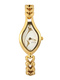
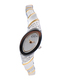

In [ ]:
# scale sparse and dense vectors
hdense, hsparse = hybrid_scale(dense, sparse, alpha=0.05)
# search
result = index.query(
    top_k=14,
    vector=hdense,
    sparse_vector=hsparse,
    include_metadata=True
)
# used returned product ids to get images
imgs = [images[int(r["id"])] for r in result["matches"]]
# display the images
display_result(imgs)

In [ ]:
for x in result["matches"]:
    print(x["metadata"]['productDisplayName'])

Titan Women Silver Watch
Titan Women Silver Dial Watch
Titan Women Silver Dial Watch
Just Cavalli Women Silver Watch
Titan Women White Watch
Miss Sixty Silver Dial Watch
Esprit Women Silver Glam Rock Houston Steel Watches
Maxima Women Silver Dial Watch
Titan Women Mother Of Pearl Watch
Titan Women White Watch
Titan Women Silver Watch
Titan Women Raga Silver Dial Watch
Titan Women Silver Dial Watch
Titan Women Silver Watch


Here we see better aligned handbags.


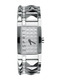
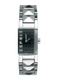
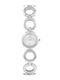
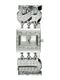
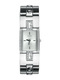
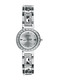
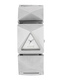
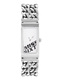
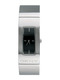
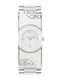
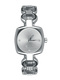
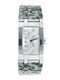
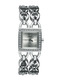
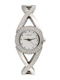

In [ ]:
# scale sparse and dense vectors
hdense, hsparse = hybrid_scale(dense, sparse, alpha=1)
# search
result = index.query(
    top_k=14,
    vector=hdense,
    sparse_vector=hsparse,
    include_metadata=True
)
# used returned product ids to get images
imgs = [images[int(r["id"])] for r in result["matches"]]
# display the images
display_result(imgs)

If we go too far with dense vectors, we start to see a few purses, rather than handbags.

Let's run some more interesting queries. This time we will use a **product image** to create our dense vector, we'll provide a text query as before that will be used to create the sparse vector, and then we'll select a specific color as per the metadata attached to each image, with [metadata filtering](https://docs.pinecone.io/docs/metadata-filtering).

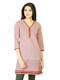

In [ ]:
images[36254]


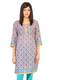
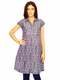
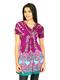
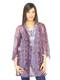
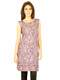
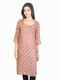
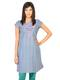
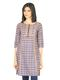
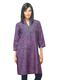
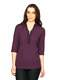
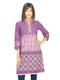
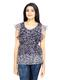
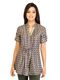
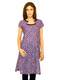

In [ ]:
query = "soft purple topwear"
# create the sparse vector
sparse = splade.encode_queries(query)
# now create the dense vector using the image
dense = model.encode(images[36254]).tolist()
# scale sparse and dense vectors
hdense, hsparse = hybrid_scale(dense, sparse, alpha=0.3)
# search
result = index.query(
    top_k=14,
    vector=hdense,
    sparse_vector=hsparse,
    include_metadata=True
)
# use returned product ids to get images
imgs = [images[int(r["id"])] for r in result["matches"]]
# display the images
display_result(imgs)

#score vs product displayname


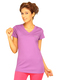
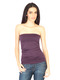
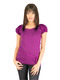
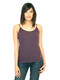
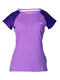
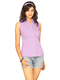
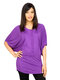
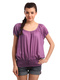
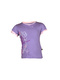
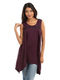
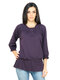
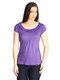
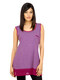
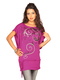

In [ ]:
query = "soft purple topwear"
# create the sparse vector
sparse = splade.encode_queries(query)
# now create the dense vector using the image
dense = model.encode(query)
# scale sparse and dense vectors
hdense, hsparse = hybrid_scale(dense, sparse, alpha=0.3)
# search
result = index.query(
    top_k=14,
    vector=hdense,
    sparse_vector=hsparse,
    include_metadata=True
)
# use returned product ids to get images
imgs = [images[int(r["id"])] for r in result["matches"]]
# display the images
display_result(imgs)

==> Nhận xét:
Tìm kiếm bằng ảnh và text thì splade thì cho hiệu quả tìm kiếm tốt hơn bm25 còn nếu chỉ query hình ảnh hoặc chỉ câu query thì BM25 hoạt động tốt hơn

Our "purple" component isn't being considered strongly enough, let's add this to the metadata filtering:


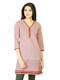
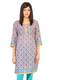
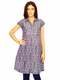
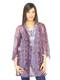
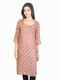
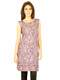
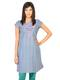
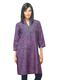
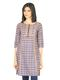
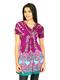
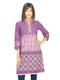
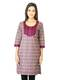
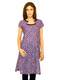
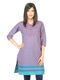

In [ ]:
query = "soft purple topwear"
# create the sparse vector
sparse = splade.encode_queries(query)
# now create the dense vector using the image
dense = model.encode(images[36254]).tolist()
# scale sparse and dense vectors
hdense, hsparse = hybrid_scale(dense, sparse, alpha=0.5)
# search
result = index.query(
    top_k=14,
    vector=hdense,
    sparse_vector=hsparse,
    include_metadata=True,
)
# used returned product ids to get images
imgs = [images[int(r["id"])] for r in result["matches"]]
# display the images
display_result(imgs)

Let's try with another image:

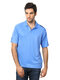

In [ ]:
images[31290]


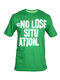
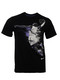
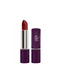
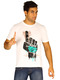
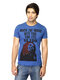
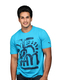
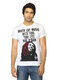
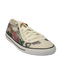
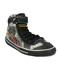
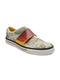
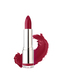
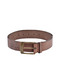
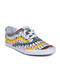
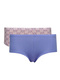

In [ ]:
query = "No oo"
# create the sparse vector
sparse = splade.encode_queries(query)
# now create the dense vector using the image
dense = model.encode(images[31290]).tolist()
# scale sparse and dense vectors
hdense, hsparse = hybrid_scale(dense, sparse, alpha=0)
# search
result = index.query(
    top_k=14,
    vector=hdense,
    sparse_vector=hsparse,
    include_metadata=True,
)
# use returned product ids to get images
imgs = [images[int(r["id"])] for r in result["matches"]]
# display the images
display_result(imgs)

Here we did not specify the gender but the search results are accurate and we got products matching our query image and description.

# Delete the Index

If you're done with the index, we delete it to save resources.

In [ ]:
pinecone.delete_index(index_name)

---